# **Final project: Basics of Mobile Robotics**

Members of the group:

* Maxime Dargent
* Alessandra Chappuis
* Julien Moreno
* Lucas Pallez

## Section 1: Introduction

The goal of this project is to combine computer vision, global and local navigation, motion control and Kalman filtering to control a Thymio robot so that it reaches an arbitrarly placed goal in the environment. Our implementation consists in taking a first frame with the camera, convert it to an occupancy grid, compute the shortest path using the Djikstra algorithm, compute and send the instruction to the Thymio's motors so that it follows the path and continuosly check whether there is an unexpected obstacle that needs to be avoided.

### Section 1.1: Libraries imports

To run the code of our project, we need multiple imports that are shown in the cell below.

In [1]:
####### 
# The lines below are meant to install packages if some are missing
#######

# !pip install tqdm scipy
# !pip install matplotlib
# !pip install opencv-contrib-python
# !pip install numpy
# !pip install --upgrade tdmclient


import matplotlib.pyplot as plt
# import time
import numpy as np
# from tqdm import tqdm
# from kalmanfilter import KalmanFilter
import cv2
# from Motion_control import MotionControl
# import local_nav as ln
# import math 
from computer_vision import Vision
# from djikstra import djikstra_algo
# from calibration import data


### Section 1.2: Connecting the Thymio robot

In [ ]:
from tdmclient import ClientAsync, aw
client = ClientAsync()
node = aw(client.wait_for_node())
aw(node.lock())

## Section 2: Calibration 

In this section, we will run multiple functions, in order to calibrate our thymio to the current environement. This gives us more flexibility, and makes it easier to use different thymio in different environments.

First, we need to initialize the calibration class.

In [ ]:
Ts = 0.1
SPEED_L = 101
SPEED_R = 98
GND_THRESHOLD = 400

mc = MotionControl(node, client, Ts, SPEED_R, SPEED_L)

### Section 2.1: Calibration of the Thymio 

In this first step, we will use the following image to calibrate the speed, its conversion ratio from the thymio's sensor to mm/s, and its variance for the Kalman filter.

<img src="Pictures/Picture1.jpg" width="900"/>

In this next function, we will ask the thymio to move forward, at a known speed. As soon as its ground sensor detect it is on the black line, it will start a timer. When it exits the line, the timer will stop, the thymio will stop aswell, and all the desired values will be computed. In this function, the line length is know and we need to be carefully align the thymio as to make it follow the line. From this test, we can also adjust the speed on the left and right wheel to make it go as straight as possible and adjust the transition threshold if the light's intensity in the current room requires it.

The following cell needs to be executed in order to initialize the calibration class, and start the calibration process. It will then give back the values in the form of a print, and give two functions we can replace the ones mentionned earlier. We have made it this way for debugging purposes. When changing code in other files that are imported, we need to restart the jupyter kernel and rerun all the cells to initialize everything. But we already know the values of the previous calibration, and if we are in the same room, with the same map and the same thymio, we know these value shouldn't change by a large margin. The two new functions will initialize everything, paste the values found earlier, and won't run the calibration process again. And if we need to change it back, the two  new functions, for the calibration process, would again be provided.

In [ ]:
cal_data = data(Ts, SPEED_L, SPEED_R, GND_THRESHOLD, client, node, 0.329506587331065, 6.793596512574189)
cal_data.calibration_mm(mc)
mc.speed_conversion = cal_data.speed_conversion

### Section 2.2: Calibration of the camera
In this next cell, we will retrieve the the grid from the camera, and do all the conversions requiered for the rest of the project. 

We initialize the vision class here, with a calibration function, because of the light's density in our current room. We often needed to adjust the threshold for multiple detection process in this class. We could've automated the process, but have decided against it, as it never was a time-consuming task. We would usually run the cell bellow with the DEBUG defined as true, check the number of obstacles, and from this, we immediatly knew what to do with our threshold value, and change it once, or twice at the very maximum.

In [ ]:
# be careful that if you have not called the previous cell, this will automatically set the missing values

DEBUG = False

nbAruco = 2
threshold = 100
calibrate = False
vision, Q_cam, R_cam = cal_data.cam_calibration(calibrate, nbAruco, threshold)

HALF_CELL_WIDTH = vision.cell_width/2
if(DEBUG == True):
    print("Number of obstacles = ", np.count_nonzero(vision.grid))
    print(vision.grid)
    lines = vision.show()
    plt.figure
    plt.title('Lines')
    plt.imshow(cv2.cvtColor(lines.astype('uint8'), cv2.COLOR_BGR2RGB))

## Section 3: The environment
We decided to discretize the environment in which the Thymio robot moves. Therefore, we created a 8x9 grid, in which all cells have the same dimension (145x145mm). Two types of obstacles can be present in the environment:
* Static obstacles: these are black squared boxes that more or less fill up the whole cell they are in, they are present in the environment since the beginning and do not move. 
* Unexpected obstacles: these can be the same as the fixed obstacles or smaller, they show up in the environment unexpectedly and are avoided thanks to local navigation.

We decided to only have 3D obstacles, as it simplifies the step after the local avoidance where the Thymio robot has to find back its path.

Due to the discretization of the environement, we also decided to limit the motion of the robot to the four directions parallel to the x-y axis of the environment. Meaning that the motion of our robot will be characterized by 90 degrees turns and straight line motion. 

Both the Thymio robot and the goal are marked with ArUco markers, the bigger one corresponds to the goal and the other one is on top of the Thymio.

The camera is placed above the environment, so that the distortion of the image is minimal.


![Alt text](Pictures/img_environment.jpg)
<center>Figure 2: Picture taken by the camera and reprensenting our environment with the Thymio robot and the goal.</center>
    


## Section 4: Computer Vision

The computer vision module is represented by the class Vision in the *computer_vision.py* file. This class allows to process and store the images, to compute the goal position and some features about the robot's position (see the attributes of the class). We used the *OpenCV* library for most of the computations in this class.

### Section 4.1: Computing the occupancy grid

The first step is to compute the occupancy grid corresponding to the environment, the Thymio robot and the goal should not be in the environment yet. This is done only once at the beginning by creating an instance of the Vision class: 

```vision = Vision()```

Which involves the following steps:

**1) Taking a picture with the camera**

**2) Processing the image**

The goal of this function is to output an image where the changes of colors, and thus the edges, can be easily identified. The adaptive threshold function allows us to do that after blurring and converting the image to B&W. This processing is enough for the next steps and does not need more processing in order to highlight the edges in our camera. 


**3) Creating and applying a mask**

To identify the environment in our image, we simply compute the contours thanks to the ```cv2.findContours()``` function and look for the contour having the biggest area. Then create a mask where the background of our image is black, while the part corresponding to the grid is white. [Source](https://maker.pro/raspberry-pi/tutorial/grid-detection-with-opencv-on-raspberry-pi)

**4) Creating a transform to resize the image**

The goal of this step is to resize the image so that ```vision.img_final``` only contains the part of the image that corresponds to the grid. To do so, we need to compute a transform that maps the edges of the environment to the smallest fitting rectangle. 
The first step is the computation of the contour with the biggest area, corresponding to the environment. To reduce the noise and thus the errors, we use the mask computed previously. Then, as suggested by this [source](https://stackoverflow.com/questions/5838506/opencv-find-skewed-rectangle), we compute the convex hull of that contour. Thanks to this [github code](https://gist.github.com/arccoder/7b98761478aace53899cd22448b80c71) we are able to compute the smallest fitting rectangle and sort the edges clockwise.

**5) Computing the occupancy grid**

To compute the occupancy grid, we need to know the number of rows and columns in the grid. To simplify the computation, we decided to give to the program those numbers. The number 1 in the grid corresponds to an obstacle, while 0 is free-space.

There is a variable ```vision.isCamOn``` that represents whether the camera was able to take a picture. If not, then the coordinates of the goal and the robot cannot be computed.


Below are shown the images obtained at each step if we use the image shown above and the corresponding grid.

ERROR MESSAGE: could not open the video stream.
ERROR MESSAGE:  cannot receive frame.


Text(0.5, 1.0, 'Final image: resized')

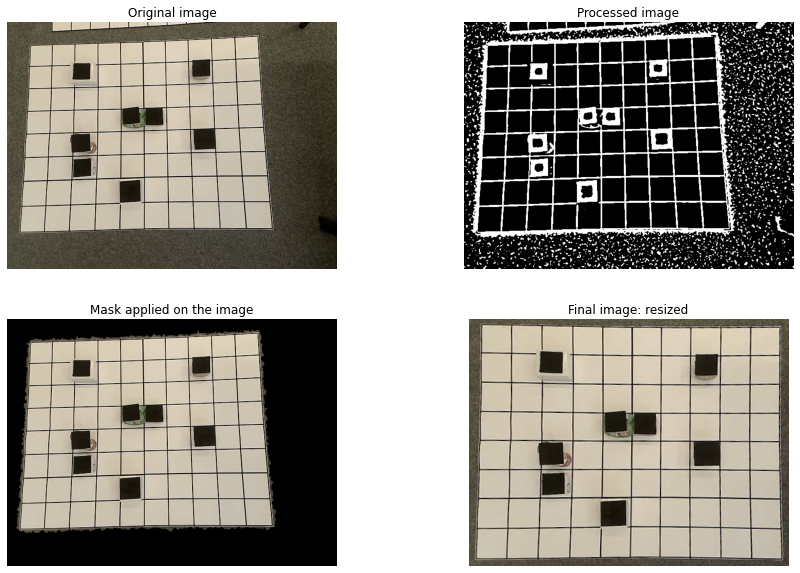

In [2]:
vision_ex = Vision()

### equivalent to vision.occupancy_grid() that is called in the initialisation of an instance
vision_ex.img = cv2.imread('Pictures/img_nothymio.png', cv2.IMREAD_COLOR)
vision_ex.image_processing()
vision_ex.create_mask()
vision_ex.apply_mask()
vision_ex.create_transform()
vision_ex.apply_transform()
vision_ex.create_grid()
vision_ex.conversion_factor_x = (vision_ex.cell_width)/vision_ex.cellx
vision_ex.conversion_factor_y = (vision_ex.cell_width)/vision_ex.celly
###

fig = plt.figure(figsize=(15, 10))

rows = 2
columns = 2

img1 = cv2.imread('Pictures/img_nothymio.png')
img2 = cv2.imread('intermediate/processedImage.png')
img3 = cv2.imread('intermediate/maskOnImage.png')
img4 = cv2.imread('output/transformedImage.png')

fig.add_subplot(rows, columns, 1)

plt.imshow(cv2.cvtColor(img1.astype('uint8'), cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Original image")

fig.add_subplot(rows, columns, 2)

plt.imshow(cv2.cvtColor(img2.astype('uint8'), cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Processed image")

fig.add_subplot(rows, columns, 3)

plt.imshow(cv2.cvtColor(img3.astype('uint8'), cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Mask applied on the image")

fig.add_subplot(rows, columns, 4)

plt.imshow(cv2.cvtColor(img4.astype('uint8'), cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Final image: resized")


Figure 3: Images created at each step of the initialization of the class Vision.

The occupancy grid corresponding to the environment is shown below:

In [ ]:
print("Occupancy grid: \n", vision_ex.grid)

As one can see in the pictures above, as well as in the code, we add an offset in the ```vision.create_transform()``` function, so that we have a border of background around the environment. This is done to avoid the case where the robot moves too close to the boundaries of the environment and its ArUco marker is cut off by the resizing of the image (due to the distortion). By adding an offset, we take into considerantion the environment and a bit of background around it, so that the ArUco marker can be seen even if the robot is close to the edges.


### Section 4.2: Compute the Thymio and goal coordinates

Once we computed the occupancy grid, both the Thymio robot and the goal can be added to the environment, and their coordinates can be calculated by calling the ```vision.update_coordinates()``` function. This call can be done as many times as needed.

In order to localize the Thymio robot and the goal, we used 4X4 ArUco markers and the ArUco library functions. Indeed, thanks to the coordinates of the four corners, we are able to estimate the pose and orientation of that marker. The choice of using ArUco markers was determined by its simplicity and its lower dependence on the lightning conditions. Indeed, we first though about using two colored circle to localize the Thymio robot and calculate its orientation, but that setup was depending a lot on the lightning and thus needed a lot of image processing to minimize that effect. To process the image before detecting the ArUco markers, we only need to convert it to B&W and apply a binary threshold that will separate the markers from the background. This threshold is set depending on the lightning of the room we are in: the more light, the smaller the threshold. 

Sometimes the ArUco markers are not detected by the camera, and thus the coordinates cannot be updated. There are multiple reasons why the markers are not detected:
* the lightning conditions changed
* an obstacle obstructs the vision of the marker on the Thymio
* the Thymio moves too close or out of to the boundaries of the environment
* ...

In those cases, the other modules need to know that they cannot use the coordinates computed by the camera. This is done by checking whether ```vision.thymio``` and ```vision.goal``` are set to ```True```. If not, this means that the corresponding marker was not detected. When a frame could not be taken, both the variables are automatically set to ```False```.

Below is the code that runs inside ```vision.update_coordinates()```. We show below an image with the estimated pose of the Thymio robot (red) and the goal (green). There is a small deviation, probably due to the many approximations we do.

The orientation of the Thymio robot is:  180.0


True

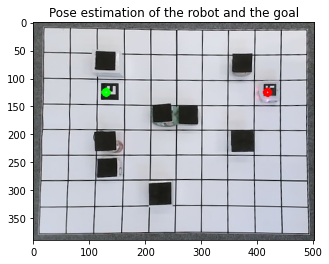

In [3]:
### equivalent to update_coordiantes()
vision_ex.img = cv2.imread('Pictures/img_thymio.png', cv2.IMREAD_COLOR)
vision_ex.threshold = 100
vision_ex.apply_mask()
vision_ex.apply_transform()
vision_ex.coordinates()
###

print("The orientation of the Thymio robot is: ", vision_ex.thymio_orientation)

img = cv2.imread('output/transformedImage.png').copy()
pos_x = round(vision_ex.offset+(vision_ex.thymio_position[0] + 0.5)*vision_ex.cellx)
pos_y = round(vision_ex.offset+(vision_ex.thymio_position[1] + 0.5)*vision_ex.celly)
cv2.circle(img, (pos_x, pos_y), 5, (0,0,255), 6)

pos_x = round(vision_ex.offset+(vision_ex.goal_position[0] + 0.5)*vision_ex.cellx)
pos_y = round(vision_ex.offset+(vision_ex.goal_position[1] + 0.5)*vision_ex.celly)
cv2.circle(img, (pos_x, pos_y), 5, (0,255,0), 6)

plt.figure
plt.title("Pose estimation of the robot and the goal")
plt.imshow(cv2.cvtColor(img.astype('uint8'), cv2.COLOR_BGR2RGB))
cv2.imwrite("output/pose.png", img)

Figure 4: Estimated pose of the robot (red) and goal (green) by the camera.

This class also allows to plot the expected path and the executes path followed by the Thymio robot. Indeed, there is a function called ```vision.create_path```, that takes the ```shortest_path``` as an argument and returns an image that shows both paths: the Dijkstra path (red) and the executed one (red).

![Alt text](Pictures/path_compare.png)
Figure 5: Comparison of the paths for a given situation.



## Section 5: Global Navigation

For the global navigation, we decided to use the Djikstra algorithm, as it is the most efficient and simple way to plan a global path in a grid.
To implement it, we used the Serie 5 of the Mobile Robotics course, and adapted it to fit to our environment : the first task was to change the grid from a square to a rectangle, adapting to any size and shape of grid. This was done by creating a ```max_val_x``` and ```max_val_y``` instead of the ```max_val``` previously implemented, and adapt it in the plot creation. 

The second task was to adapt the grid so that the points would appear in the middle of the cells, and not on intersections like in the Serie 5. That was implemented in the function ```create_empty_plot``` of *djikstra.py* : we used major ticks as the true coordinates of our path, and hid the lines. We then set the minor ticks to coord-0.5 in order to have the cells being drawn. We also had to invert the y axis, as in computer vision, a picture has the origin on the top left of the frame, whereas in the grid previously implemented, the origin was on the bottom left of the frame. The improvements are shown in Fig.

In [ ]:
import IPython.display as display
import ipywidgets as widgets

img1=open('Pictures/djikstrabad4N.png','rb').read()
wi1 = widgets.Image(value=img1, format='png', width=350, height=500)
img2=open('Pictures/djikstragood4N.png','rb').read()
wi2 = widgets.Image(value=img2, format='png', width=350, height=500)
a=[wi1,wi2]
wid=widgets.HBox(a)
display.display(wid)

<div align="center">Figure 5 : Shortest path with Djikstra algorithm showed on a rectangular grid with the position of the thymio on the intersection(left) and in the center of each cell (right)

Another task was to block certain movements : our first iteration of the djikstra algorithm worked for the '8N' movements. In that case, the algorithm theoretically passes through in every diagonal if the cell is free. In reality, the robot doesn't have the space to go through. We implemented a condition in the Astar function to be able to prevent this situation.
```
if deltacost == math.sqrt(2) :
   if (occupancy_grid[neighbor[0]-np.sign(dx), neighbor[1]]) or (occupancy_grid[neighbor[0], neighbor[1]-np.sign(dy)]): 
      continue
```
**This condition wasn't implemented in the final project, because the group decided to go with 4N movements to make kalman filtering easier.**

![Alt text](Pictures/djikstra8N.png)
<div align="center">Figure 6 : Shortest path with Djikstra algorithm on a grid with the 8N type movements showing the condition to prevent imppossible movements in diagonal on coordinates (8,13)->(9,14)

## Section 6: Local Navigation

For the local navigation module, we decided to go with a simple yet efficient method : we proceed to follow the obstacle until the path is free again. The top level implementation is shown in Fig. We used a finite state machine to describe the local avoidance process. 

![Alt text](Pictures/local_fsm.png)

Figure 7 : Finite State Machine of the local navigation : the state of the thymio robot can switch from HORIZONTAL_MOVE to VERTICAL_MOVE to OBST_TO_PATH and inversly


When an obstacle is detected (the function obstacle_detect returns true) the robot will turn right to try to get around the obstacle. At this point the robot will be in the **HORIZONTAL_MOVE** state. If an obstacle is detected on the right, a variable called going_left is set to '1' and the robot tries to get around the obstacle from the left.

![Alt text](Pictures/local_left.png) 
<center>Figure 8 : simulation scenario of the local navigation : if the robot is blocked on the right and in the front, it will activate a boolean going_left and avoid the obstacle from the left</center>


In both cases, the robot will continue going forward until the sensors on the side (0 if the robot is turning right and 4 if it is turning left) do not detect the obstacle anymore, and a formula integrated in the function will make the thymio go one case further to stay in the center of the cell and make sure it has space to turn. If the thymio has successfully passed the obstacle honrizontally, it switches to **VERTICAL_MOVE**. In that state, the robot will try to get around the obstacle vertically. The robot will continue going forward until either the sensors on the side do not detect the obstacle anymore or if there is an obstacle in the front. In the last case, it will switch back to **HORIZONTAL_MOVE** state and go further away from the obstacle to get around it.

![Alt text](Pictures/local_HVHV.png) 
<center>Figure 9 : simulation scenario of the local navigation : if the robot sees an obstacle while being in the vertical move state, it can go back to the horizontal state to get around it
</center>


If there is not obstacle at the front, it can switch to the **OBST_TO_PATH** state. In this state, the robot will try to go back to the point he was supposed to be after the obstacle.

![Alt text](Pictures/local_normal.png) 
<center>Figure 10 : simulation scenario of the local navigation : typical run of the local avoidance function, moving from the HORIZONTAL_MOVE to the VERTICAL_MOVE to the OBST_PATH_MOVE state directly.
</center>


However, this behavious is not optimized, because the robot could in that case go through a cell that is part of the path and still go back to the cell and then come back to the same cell. We then decided to include the shortest path as a parameter of the function obstacle_avoid, to be able to check if the coordinates of the robot is part of the path. In that case the robot will switch back to the main master function, sending it's coordinates and orientation.  

![Alt text](Pictures/local_path.png)
<center>Figure 11 : simulation scenario of the local navigation : if the robot crosses the path without being at the goal, it still joins the path
</center>


## Section 7: Kalman Filtering

The filter we have chosen to use is the kalman's filter. With the use of the camera, and the thymio's speed sensor, we have two different sensor with which we can use the Kalman's filter. It's implementation is traditionnal. Again, we have gone for the usage of a class, as it makes it easier to use, and track the values. 
The one section where we had room to play with, were the values of the covariance of process noise's matrices Q, and the values of the covariance of the measurement's noise R.

 $R = \begin{bmatrix} r_p & 0\\ 0 & r_\nu \end{bmatrix}$
 $Q = \begin{bmatrix} q_p & 0\\ 0 & q_\nu \end{bmatrix}$

The values have been computed using the same method as in the exercise of week 8. The $r_\nu$ and $q_\nu$ have been computed inside the calibration process. For $q_p$ and $r_p$, it was a little bit more difficult. An issue we had, was the deformation of the image due to the lens, and the position of the camera. 

<img src="Pictures/Camera_pos.jpg" />

When placing the camera, we always placed it perfectly in the middle of the grid along its x axis, but because of our setup, we could never place it in the middle of its width along the y axis aswell. It was always on the side. This induced an error on the y position of the thymio. We have fixed it by placing a y_offset in the vision class. With this offset, we managed to correct the position in y from the camera's perspective, but it wasn't perfect either. We still had an error of approximatively ±5mm. Based on the exercise of week 8 again, we decided to set $r_p$ = 0.01 But while testing this, we also managed to see the variance on the position from the camera's perspective. We found from this that the standard deviation was ~0.5mm, so we have set $q_p$ =  0.25mm


For this filter, we've inspired ourselves from the courses and the youtuber "L42" and his [github](https://github.com/L42Project/Tutoriels/tree/master/Divers/tutoriel36), to properly understand the filter. 


## Section 8: Motion control
The motion control module regroups every functions related to the thymio's various movements. In there is located the motors function which makes the thymio move according to the left and right speed. Other functions are used to estimate the next trajectory of the robot : get_turn and correct_orientation: get_turn computes the movement needed for the thymio to get to the orientation desired according to the next coordinates in the Djikstra algorithm and the actual orientation. To prevent useless turns, we substract or add 4 to the movement in case it is superior to 2. That means that is the robot wants to turn 270°, it will turn -90° instead. correct_orientation is usefull to make sure that even if the camera measures an angle that is not exactly a multiple of 90°, the orientation set for the thymio is still correct, taking into account an error in the measure.

A function has been implemented to make the robot turn : indeed, the center of rotation of the thymio isn't located at it's center; when we try to have both motor running at opposite speeds, that causes the robot's center after a turn to be far from the center of the cell. We decided to implement a perpendicular parking like behaviour, calibrating the values to be able to fit in the cells. 

![Alt text](Pictures/turn.png)
<center>Figure 13 : simulation scenario of the movement of the thymio when it does a 90° turn in the left direction : it is done in 3 steps
</center>

### Section 8.1: Kalman_adjust

With the kalman filter, we get an estimated position of our thymio, from our multiple sensor. But we still need to use these informations. Because of our environement and path finding choices, we have decided to run the Kalman_adjust per cell. This means that we will run the correction *per steps*. We take the center of our thymio from the kalman's estimated position, and take the difference with the center of the next targeted cell. The goal is for the thymio to face the center of this cell. This is what Kalman_adjust do. It computes the angle required to reach the center of the next targeted cell, compares it with the actual thymio's orientation, and runs a proportionnal controller to fix the error. We found two approaches: in both case, we increase the speed of one wheel, while we decrease the speed of the other. This will lead to a rotation of the thymio. Then we could either decide to let this different in speed be, and expect kalman to correct the speed at every sampling time, or, the second approach, the one we went with, set this difference in speed, and let it run for a little time, then reset the speed back to normal. We have decided to set the duration to two sampling time, to be sure it would be long enough for it to affect the locomotion. The first option has also been tested, but resulted in a lot of oscillation from the thymio.

The gain was set experimentally. We know that the $k_p * \omega * t$  ($\omega$ being the angular velocity) shouldn't exceed the difference in angle from the desired orientation and the actual one. We could've increased the gain up to this limit but found the value of 2.5 was good enough, without being too agressive.
Finally, we have also made the choice of ignoring a difference in angle bellow our threshold of 7°, because of this imperfection of our setup, and the camera's deformation.

## Section 9: Master interface
The master interface is a function which regroups every module together to make the robot go from start to goal. The implementation is the following : from the computer vision's occupancy grid, we retrieve the shortest path with the djiksta algorithm. We then start a loop taking each dx and dy in shortest path, dx and dy being the absolute index in the grid. At each iteration, we update the camera and correct the angle of the thymio. Then, if neccessary, the thymio turns according to the new coordinates desired. It then checks if there is any obstacle in front of him before going forward. If that's the case, it stays in the local loop while the thymio hasn't passed around the obstable. Then the master loop turns empty thanks to the jump variable, until the neew coordinates of the thymio match the global path. 

If there is no obstacle in front of him, the thymio won't need to go in local navigation mode, and can move freely forward, with a distance of one cell. During this movement, the kalman filtering is applied to make sure that the robot stays in the right direction. When the movement is done, the coordinates x and y actualize with the value of dx and dy. 

If the goal is moved during the process, a check is done every step; if that is the case, we break from the loop of the shortest path to recalculate the new path with djikstra, as well as reinitializing the filter.

In [ ]:

mc.step_duration = HALF_CELL_WIDTH*2 / (mc.SPEED_AVG * mc.speed_conversion)
mc.turn_duration = 98 / (mc.SPEED_AVG * mc.speed_conversion)
restart = True

jump_x, jump_y = 0,0
MARGIN = 40
change_dir = False
while (restart == True):
    jump = False
    index = 0
    restart = False
    vision.update_coordinates()
    if(DEBUG == True):
        print("thymio real pos : ", vision.thymio_real_pos)
        print("thymio pos in grid : ", vision.thymio_position)
        print("goal pos : ", vision.goal_position)
        print("thymio angle = :", vision.thymio_orientation)
    vision.grid[vision.thymio_position[1]][vision.thymio_position[0]] = 0
    vision.grid[vision.goal_position[1]][vision.goal_position[0]] = 0
    shortest_path = djikstra_algo(vision.grid.T, vision.thymio_position, vision.goal_position)
    if(DEBUG == True):
        print(shortest_path)
    KF = KalmanFilter(Ts, vision.thymio_real_pos, cal_data.speed_conversion, Q_cam, R_cam)
    mc.orientation = mc.correct_orientation(vision.thymio_orientation)
    x = vision.thymio_position[0]
    y = vision.thymio_position[1]
    speed = np.array([SPEED_L, SPEED_R])
    turn_speed = np.array([0, 0])
    for dx,dy in np.transpose(shortest_path):
        if jump:
            x = dx      #actualize the coordinates of the robot
            y = dy      #actualize the coordinates of the robot
            index += 1
            if jump_x == dx and jump_y == dy:
                jump = False
            continue  
        vision.update_coordinates()
        if(vision.goal_position != vision.goal_previous) & (change_dir != True):
            change_dir = True
            restart = True
            break
        turn = mc.get_turn(dx-x,dy-y,mc.orientation)
        mc.orientation = (mc.orientation + turn)%4
        for i in range(abs(turn)):
            mc.robot_turn(np.sign(turn))
        mc.adjust_angle(vision)
        if (((dx-x)!=0) | ((dy-y)!=0)):
            local = ln.obstacle_detect(node)
            if local:
                if(DEBUG == True):
                    print("obstacle",len(shortest_path[1]))
                jump,jump_x,jump_y = ln.obstacle_avoid(vision, mc, x, y, shortest_path, index, node, client)
            else:   
                if (((dx-x)!=0) | ((dy-y)!=0)):
                    step_done = False
                    start_move = time.time()
                    mc.motors(speed[0], speed[1])
                    temp = 0
                    next_target_x = dx *HALF_CELL_WIDTH*2 + HALF_CELL_WIDTH
                    next_target_y = (vision.rows - 1 - dy) *HALF_CELL_WIDTH*2 + HALF_CELL_WIDTH
                    
                    while (step_done != True):  
                        vision.update_coordinates()
                        kalman_pos= KF.filter(vision.thymio, vision.thymio_real_pos, speed, vision.thymio_orientation)
                        if(DEBUG == True):
                            print("estimated position ", kalman_pos)
                            print("position from camera ", vision.thymio_real_pos)
                        delta_x, delta_y= mc.kalman_adjust(next_target_x, next_target_y, kalman_pos, vision.thymio_orientation)
                        current = time.time()
                        temp = current - start_move
                        if((np.abs(delta_x) < MARGIN) & (np.abs(delta_y) < MARGIN)):
                            step_done = True
                            mc.motors(0, 0) 
                        elif(temp > mc.step_duration):
                            step_done = True  
                            mc.motors(0, 0)
                
                    mc.adjust_angle(vision)

        x = dx      #actualize the coordinates of the robot
        y = dy      #actualize the coordinates of the robot
        index += 1

## Section 10: Conclusion

This project being made of random groups, and over a very short time, forced us to cooperate and communicate properly. We managed to work all together, and help each other face problem we all faced. The task was certainly not always easy, but having this cooperation inside the group was a key aspect of the work we have done.

We've also learned, with a practical point of view, how path finding, local navigation, image processing and the filtering actually works

We have set a defined goal for this project and feel we have managed to succeed. Surely, we could've made some aspect of our project more raffined, ellaborate, and/or versatile, but given the time available for this project, shared with other project with other group, we are happy with the results.

## Section 11: Demonstration

You can find a demonstration run of our project at the following link : https://drive.google.com/drive/folders/1M95SnwzH_0C-xljhxi9llSEg_ssDAt28